In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tp3
import utm
np.random.seed(42)

In [2]:
def crear_matriz(anchor_dict):
    # Construcción de la matriz A y el vector b para el sistema Ax = b
    # Cada ancla aporta una fila a A y un elemento a b
    # La fila i de A es [1, -tan(theta_i)]
    # El elemento i de b es x_i - tan(theta_i) * y_i donde (x_i, y_i) es la posición de la ancla i y theta_i es el ángulo medido desde la ancla i
    rows = []
    bs = []
    for key,value in anchor_dict.items():
        xi,yi = value["pos"]
        theta = value["angulo"]

        t = np.tan(theta)

        rows.append([1.0,-t])
        bs.append(xi - t * yi)
    
    return np.array(rows), np.array(bs)

In [3]:
def ls(A,b):
    # Solución de cuadrados mínimos
    return np.linalg.inv(A.T @ A) @ A.T @ b

def plot_results(ax, anchors, p_true, p_est=None, title=None, ests=None):
    xs = []
    ys = []
    for k, v in anchors.items():
        xi, yi = v["pos"]
        xs.append(xi)
        ys.append(yi)

    ax.plot(xs, ys, 'o', label="Anclas")
    ax.plot(p_true[0], p_true[1], 'o', label="Posición real", markersize=10)

    if p_est is not None:
        ax.plot(p_est[0], p_est[1], 'x', label="Estimación", markersize=15)

    if ests is not None:
        ax.plot(ests[:,0], ests[:,1], 'x', alpha=0.6, label="Estimaciones ruidosas")

    ax.set_aspect('equal', 'box')
    ax.grid(True)
    if title:
        ax.set_title(title)
    ax.legend()

In [4]:
def simular_ruido(anchors, sigma2, n_real=50):
    sigma = np.sqrt(sigma2)
    ests = np.zeros((n_real, 2))
    keys = list(anchors.keys())

    for i in range(n_real):
        noisy = {}
        for k in keys:
            xi, yi = anchors[k]["pos"]
            theta = anchors[k]["angulo"]
            dx = np.random.normal(0, sigma)
            dy = np.random.normal(0, sigma)
            noisy[k] = {"pos": (xi + dx, yi + dy), "angulo": theta}

        A, b = crear_matriz(noisy)
        ests[i, :] = ls(A, b)

    return ests

Inciso A)

Ejercicio 2(a)
Posición real: [100  50]
Estimación sin ruido: [100.  50.]


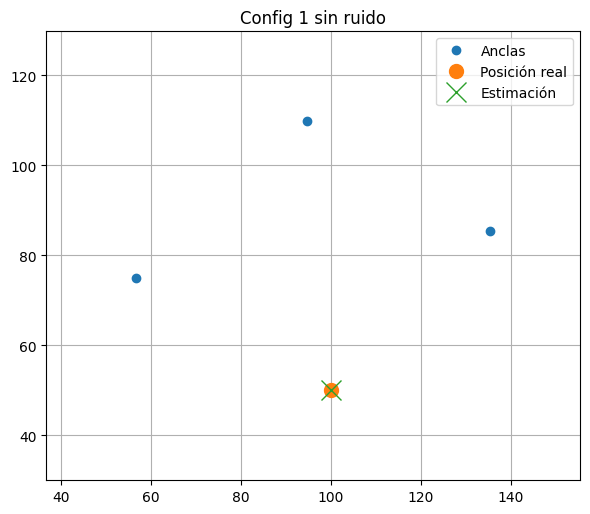

In [5]:
p_true = np.array(tp3.p)
config_1 = tp3.config_1
A1, b1 = crear_matriz(config_1)
p_hat1 = ls(A1, b1)

print("Ejercicio 2(a)")
print("Posición real:", p_true)
print("Estimación sin ruido:", p_hat1)

all_x = [p_true[0]] + [v["pos"][0] for v in config_1.values()]
all_y = [p_true[1]] + [v["pos"][1] for v in config_1.values()]
xmin, xmax = min(all_x)-20, max(all_x)+20
ymin, ymax = min(all_y)-20, max(all_y)+20

fig, ax = plt.subplots(figsize=(6, 6))
plot_results(ax, config_1, p_true, p_hat1, "Config 1 sin ruido")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.tight_layout()
plt.show()

Inciso B)

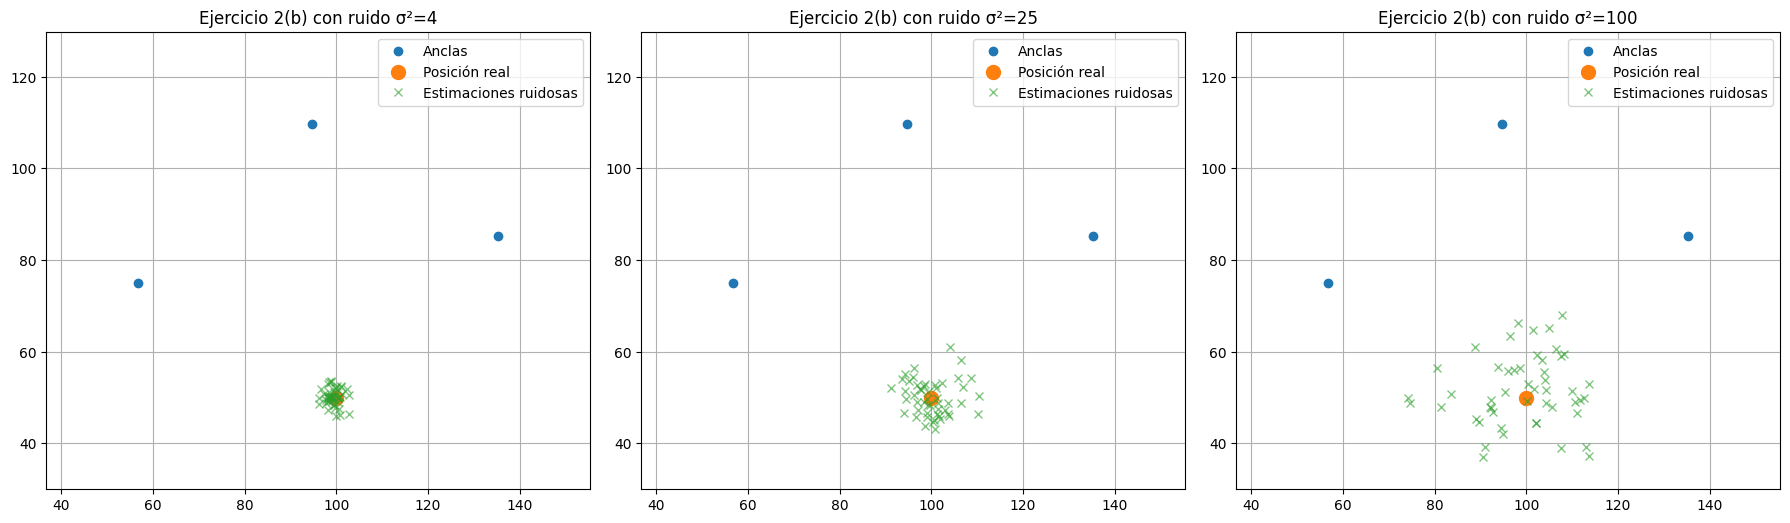

In [6]:
sigma2 = [4, 25, 100]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for ax, s2 in zip(axs, sigma2):
    ests = simular_ruido(config_1, s2, n_real=50)
    plot_results(ax, config_1, p_true, title=f"Ejercicio 2(b) con ruido σ²={s2}", ests=ests)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

Inciso C)

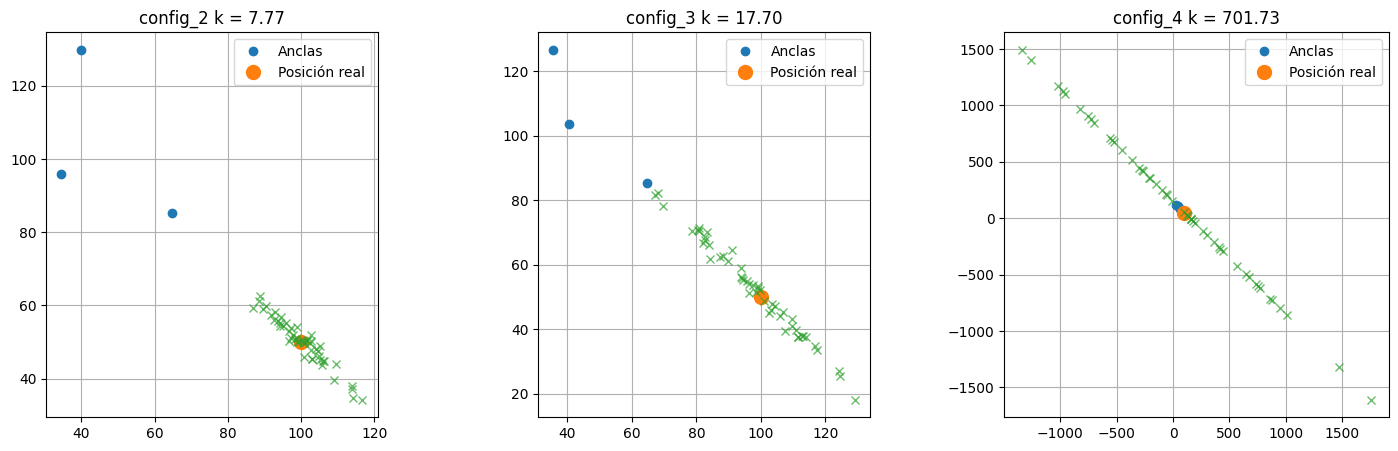

Configuración  Condición (k)  Media x  Media y  Desvío estándar x  Desvío estándar y
     config_2           7.77  100.235   50.136              6.835              6.441
     config_3          17.70   97.594   52.847             14.550             14.595
     config_4         701.73   36.506  113.665            672.713            672.747


In [7]:
sigma2 = 4
configs = {"config_2": tp3.config_2, "config_3": tp3.config_3, "config_4": tp3.config_4}

summary = []
fig, axs = plt.subplots(1, 3, figsize = (18,5))
for (name, cfg), ax in zip(configs.items(), axs):
    A, b = crear_matriz(cfg)
    kappa = np.linalg.cond(A)
    ests = simular_ruido(cfg, sigma2, n_real = 50)

    # Graficos
    plot_results(ax, cfg, p_true, None, title=f"{name} k = {kappa:.2f}")
    ax.plot(ests[:,0], ests[:,1], 'x', alpha = 0.7)

    # Estadísticas
    mean_est = ests.mean(axis = 0)
    std_est = ests.std(axis = 0)
    summary.append((name, kappa, mean_est, std_est))

plt.show()

# Resumen de resultados en tabla
df = pd.DataFrame(summary, columns = ["Configuración", "Condición (k)", "Media estimaciones", "Desvío estándar"])
df["Media x"] = df["Media estimaciones"].apply(lambda v: round(v[0], 3))
df["Media y"] = df["Media estimaciones"].apply(lambda v: round(v[1], 3))
df["Desvío estándar x"]  = df["Desvío estándar"].apply(lambda v: round(v[0], 3))
df["Desvío estándar y"]  = df["Desvío estándar"].apply(lambda v: round(v[1], 3))

df = df.drop(columns=["Media estimaciones", "Desvío estándar"])
df["Condición (k)"] = df["Condición (k)"].round(2)

print(df.to_string(index=False))

### Experimento

Verificación conversión inversa: 34.26479999980162, 58.314500000007705

Ejercicio 3 (Experimento con márgenes de error)
Posición real: [ 621017.17500274 3792298.77967099]
Estimación: [ 621020.80570498 3792296.04477554]
Radio de incertidumbre aproximado: 11.65 m


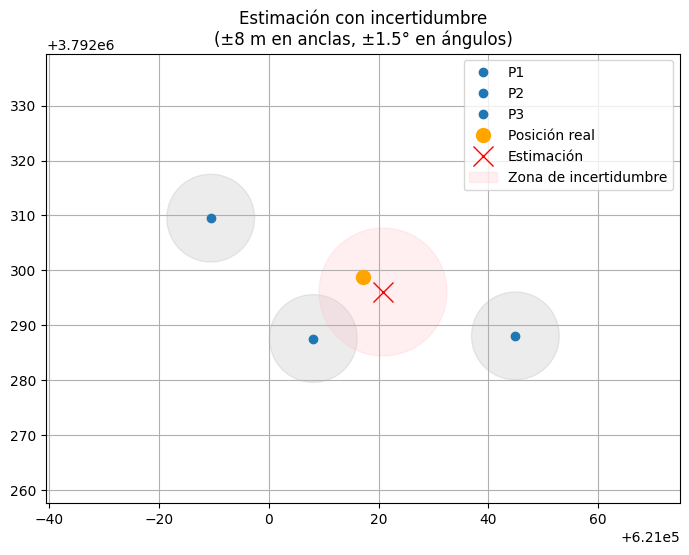

In [13]:
def wgs84_to_utm(lat, lon):
    return utm.from_latlon(lat, lon)

def utm_to_wgs84(easting, northing, zone_number, zone_letter):
    return utm.to_latlon(easting, northing, zone_number, zone_letter)


# Coordenadas de Escultura
lat1, lon1 = 34.2647, 58.3148
# Coordenadas del Triangulo Cafetería
lat2, lon2 = 34.2647, 58.3144
# Coordenadas del Monsegur
lat3, lon3 = 34.2649, 58.3142

e1, n1, *_ = wgs84_to_utm(lat1, lon1)
e2, n2, *_ = wgs84_to_utm(lat2, lon2)
e3, n3, *_ = wgs84_to_utm(lat3, lon3)

# Error de medición Google Earth
ERROR_POS = 8.0     # 8 metros

# Error angular (en radianes)
ERROR_ANG = np.deg2rad(1.5)

# Datos de medición
medicion = {
    "P1": {"pos": (e1, n1), "angulo": -1.22173},
    "P2": {"pos": (e2, n2), "angulo":  0.994838},
    "P3": {"pos": (e3, n3), "angulo":  2.00713},
}

# Posición nuestra (real)
lat, lon = 34.2648, 58.3145
e, n, zn, zl = wgs84_to_utm(lat, lon)
latm, lonm = utm_to_wgs84(e,n,zn,zl)
print(f"Verificación conversión inversa: {latm}, {lonm}")

p_real_exp = np.array([e, n])

# Estimación sin errores
A_exp, b_exp = crear_matriz(medicion)
p_est = ls(A_exp, b_exp)

print("\nEjercicio 3 (Experimento con márgenes de error)")
print("Posición real:", p_real_exp)
print("Estimación:", p_est)

# Aplica los límites máximos de error
def estimaciones_extremas(medicion):
    ests = []
    for dx in [-ERROR_POS, ERROR_POS]:
        for dy in [-ERROR_POS, ERROR_POS]:
            for da in [-ERROR_ANG, ERROR_ANG]:

                pert = {}
                for k, v in medicion.items():
                    x, y = v["pos"]
                    ang = v["angulo"]

                    pert[k] = {
                        "pos": (x + dx, y + dy),
                        "angulo": ang + da
                    }

                A, b = crear_matriz(pert)
                est = ls(A, b)
                ests.append(est)

    return np.array(ests)

# Cálculo de las estimaciones extremas
ests_ext = estimaciones_extremas(medicion)

# Radio de incertidumbre
distancias = np.linalg.norm(ests_ext - p_est, axis=1)
radio_error = np.max(distancias)

print(f"Radio de incertidumbre aproximado: {radio_error:.2f} m")

fig, ax = plt.subplots(figsize=(7, 7))

# Anclas + círculos de error
for name, v in medicion.items():
    x, y = v["pos"]
    ax.plot(x, y, 'o', color='tab:blue', label=f"{name}")

    # Círculo de error Google Earth ±8m
    circ = plt.Circle((x, y), ERROR_POS, color='gray', alpha=0.15)
    ax.add_patch(circ)

# Posición real
ax.plot(p_real_exp[0], p_real_exp[1], 'o',color = 'orange', markersize=10, label="Posición real")

# Estimación central
ax.plot(p_est[0], p_est[1], 'x',color = 'red', markersize=15, label="Estimación")

# Círculo naranja de incertidumbre final
circ2 = plt.Circle((p_est[0], p_est[1]), radio_error, color='pink', alpha=0.25, label="Zona de incertidumbre")
ax.add_patch(circ2)

# Ajustes del gráfico
all_x = [p_real_exp[0]] + [v["pos"][0] for v in medicion.values()]
all_y = [p_real_exp[1]] + [v["pos"][1] for v in medicion.values()]
xmin, xmax = min(all_x) - 30, max(all_x) + 30
ymin, ymax = min(all_y) - 30, max(all_y) + 30

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_aspect('equal', adjustable='box')
ax.grid(True)
ax.set_title("Estimación con incertidumbre\n(±8 m en anclas, ±1.5° en ángulos)")
ax.legend()

plt.tight_layout()
plt.show()